In [1]:
# Imports
import pandas as pd
import geopandas as gpd
from pyproj import CRS
import matplotlib.pyplot as plt
import contextily as ctx
import osmnx as ox
import networkx as nx
from shapely.geometry import LineString, Point, Polygon, MultiPoint
from shapely.ops import nearest_points
from shapely.ops import unary_union
from shapely import speedups
from geopy.geocoders import Nominatim
from geopandas.tools import geocode
from geopy.extra.rate_limiter import RateLimiter
import datetime
import folium
import geojson
import os
import glob

%matplotlib inline

## Notebook structure
I have divided the code into 4 sections. Section 1 gathers user inputs and appropriate travel time data, section 2 calculates travel time and estimated time of arrival between an user-defined address-destination pair, section 3 downloads OSM street network data and calculates the shortest path from origin to destrination loacation and section 4 combines all of the route information into an interactive map. At the end I conclude on some reflections on the exercise.

## 1. User inputs and travel time data selection
The travel time calculation begins with getting the user input. Origin and destination addresses, trvel mode and departure time are all customizable.

**Notes about the user input**

`Origin address:` Every Address in the Helsinki region (Helsinki, Espoo, Vantaa) should work as origin input. However, due to the logic I later on use to limit the size of OpenStreetMap (OSM) network data to download, routes that cross large water bodies (for example a route from Herttoniemi to Kumpula) are not optimal as they will most likely result in an incomplete path calculation. 

`Destination address:` Destinations are limited to Helsinki univeristy campuses. This is done to limit the amount of files needed for the tool to operate. Below is a list of functionoing destination addresses.

Functioning destinations:
- Gustaf Hällströmin katu 2, Helsinki = Kumpula
- Haartmaninkatu 8, Helsinki = Meilahti
- Viikinkaari 11, Helsinki = Viikki
- Yliopistonkatu 3, Helsinki = Porthania
- (and technically any other addresses that are located within the same YKR grid cells as one of the uni campuses)

`Travel mode:` Four different travel modes are available (walk, bike, public, car). Travel mode info is used to pick the correct travel time info from the matrix and to select the correct network type when downloading the road network from OSM. Espcially on longer routes the "walk" option results in longer run times as the network is a lot more dense. One thing to note as well is that the bike network seems to be the one most prone to errors when routing: some routes that work with other travel modes fail with the bike option (I have no idea why).

`Departure time:` Desired time of departure can be chosen manually or the user can opt to use current time in Helsinki. This info is used in calculating the estimated time of arrival and to indicate wether the trip takes place during the rush hour.

**1.1. User inputs**

In the first cell I gather and process all of the user inputs. The cell geocodes the addresses into location data (correctly projected point geometries), saves travel mode informtion into a variable and either formats a user defined time into a datetime object or uses current time in Helsinki. I also provide a hashtagged example of the input in case the notebook needs to be run multiple times (typing input every time gets old quite fast).

In [2]:
# User-defined addresses, travel mode and departure time
orig_address = str(input('Origin address (Street name and number, city):')+', Finland')
dest_address = str(input('Destination address (Street name and number, city):')+', Finland')
travel_mode = str(input('Travel mode (walk, bike, public, or car):').lower()) 
user_time = str(input('Departure time (hh:mm)\n(Write "now" or leave this field empty to use current time in Helsinki as departure time):').lower())

# An example
#orig_address = 'tiedepuisto 1, vantaa'+', Finland'
#dest_address = 'Gustaf Hällströmin katu 2, Helsinki'+', Finland'
#travel_mode = 'car'.lower()
#user_time = '09:15'.lower()

# Geocode addresses
orig_point = geocode(orig_address, provider='nominatim', user_agent='autogis_EH', timeout=10)
dest_point = geocode(dest_address, provider='nominatim', user_agent='autogis_EH', timeout=10)

# Project to ETRS-TM35FIN (same as the YKR grid)
orig_point = orig_point.to_crs(epsg=3067)
dest_point = dest_point.to_crs(epsg=3067)

# Define current time in Helsinki (UTC + 2 hours)
time_hki = datetime.datetime.utcnow()+datetime.timedelta(hours=2)

# Set departure time (current time in Helsinki or user-defined time)
if not user_time or user_time == 'now':
    # Use current Helsinki time as start time
    departure_time = time_hki
else:
    # String slice user-defined time to a datetime object and use that as departure time instead
    user_hour = int(user_time[0:2])
    user_min = int(user_time[3:5])
    departure_time = datetime.datetime(
        year=time_hki.year,
        month=time_hki.month,
        day=time_hki.day,
        hour=user_hour,
        minute=user_min
    )

Origin address (Street name and number, city): Aamupäivänkuja, Espoo
Destination address (Street name and number, city): Viikinkaari 11, Helsinki
Travel mode (walk, bike, public, or car): car
Departure time (hh:mm)
(Write "now" or leave this field empty to use current time in Helsinki as departure time): 


Now I read in the YKR grid and check projections.

In [3]:
# Read in the YKR grid
fp_grid = r'data/YKR/MetropAccess_YKR_grid_EurefFIN.shp'
grid = gpd.read_file(fp_grid)

# Check projections
if grid.crs == orig_point.crs == dest_point.crs:
    print('data is correctly projected')
else:
    print('projections do not match')

data is correctly projected


**1.2. Travel time data selection**

Every text file that makes up the travel time matrix is named with the `YKR ID` of the cell of the YKR grid that the travel times are calculated to. So, to find what travel time files to use in the travel time calculation I need to find the `YKR ID`s of the YKR grid cells that have the origin and destination points within them. I can also automatically download the correct travel time file by defining its filepath based on the `YKR ID` of the grid cell that contains the destination location. 

I find the `YKR ID`s by first defining a centroid for every cell in the YKR grid and then finding the closest centroids to both the origin and address locations. The grid centroids are created based on the pre existing x and y columns in the YKR grid.

In [4]:
# Define centroids of all of the YKR grid cells

# Dataframe for centroids
grid_centroids = gpd.GeoDataFrame()

# Define a centroid for every grid cell
grid_centroids['geometry'] = gpd.points_from_xy(grid.x, grid.y)

# Keep the YKR_ID information for data selection
grid_centroids['YKR_ID'] = grid['YKR_ID']

# Check Results
grid_centroids.head()

,geometry,YKR_ID
0,POINT (381875.000 6697880.000),5785640
1,POINT (382125.000 6697880.000),5785641
2,POINT (382375.000 6697880.000),5785642
3,POINT (382625.000 6697880.000),5785643
4,POINT (381125.000 6697630.000),5787544


To get the the `YKR ID` value of the cell centroids that are nearest to the origin and destination points I use a function from lesson 3. The function finds the nearest points and their values in a specified column (`YKR_ID` in this case) so the function is a perfect match for this problem.

In [5]:
# Define a function for getting the YKR_ID values of the nearest cell centroids
def get_nearest_values(row, other_gdf, point_column='geometry', value_column='geometry'):
    """Find the nearest point and return the corresponding value from specified value column."""
    
    # Create an union of the other GeoDataFrame's geometries:
    other_points = other_gdf['geometry'].unary_union
    
    # Find the nearest points
    nearest_geoms = nearest_points(row[point_column], other_points)
    
    # Get corresponding values from the other df
    nearest_data = other_gdf.loc[other_gdf['geometry'] == nearest_geoms[1]]
    
    nearest_value = nearest_data[value_column].values[0]
    
    return nearest_value

To find the `YKR ID`s of the cells that contain the origin and destination I apply the function to the origin and destination point geodataframes. I also assign the `YKR ID` values of destination and origin cells into their own variables.

In [6]:
# Find closest centroid to orig_point 
orig_point['YKR_ID'] = orig_point.apply(
    get_nearest_values,
    other_gdf=grid_centroids,
    point_column='geometry',
    value_column='YKR_ID',
    axis=1
    )

# Find closest centroid to dest_point
dest_point['YKR_ID'] = dest_point.apply(
    get_nearest_values,
    other_gdf=grid_centroids,
    point_column='geometry',
    value_column='YKR_ID',
    axis=1
    )

# Assign YKR_IDs to variables (value of the desired column at index 0 as there is only one origin and destination)
orig_YKR = orig_point['YKR_ID'].iloc[0]
dest_YKR = dest_point['YKR_ID'].iloc[0]

# Check results
print('Origin:',orig_YKR, '\nDestination:', dest_YKR)

Origin: 5973693 
Destination: 5931307


Next I format the filepath used to download the travel time file based on the `YKR ID` of the destination cell. With this filepath I download the correct data. I also merge the travel time text file to the YKR grid based on the matching `from_id` columns. 

In [7]:
# Select appropriate travel time data based on dest_point's YKR_ID (Only 4/13 231 possible files uploaded to git)
fp_tt = r'data/traveltimes/travel_times_to_ '+str(dest_YKR)+'.txt'

# Read in data
tt_data = pd.read_csv(fp_tt, sep=';', na_values=['-1'])

# Merge travel time data to YKR grid
tt_grid = grid.merge(tt_data, on=tt_data['from_id'])

# Check results
tt_grid.head()

,key_0,x,y,YKR_ID,geometry,from_id,to_id,walk_t,walk_d,bike_s_t,...,pt_r_t,pt_r_d,pt_m_tt,pt_m_t,pt_m_d,car_r_t,car_r_d,car_m_t,car_m_d,car_sl_t
0,5785640,381875.0,6697880.0,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6...",5785640,5931307,423.0,29619.0,121.0,...,117.0,34099.0,157.0,126.0,41217.0,54.0,34700.0,48.0,34700.0,31.0
1,5785641,382125.0,6697880.0,5785641,"POLYGON ((382250.000 6697750.000, 382000.000 6...",5785641,5931307,386.0,27003.0,118.0,...,120.0,34305.0,164.0,128.0,33041.0,55.0,34911.0,47.0,34911.0,31.0
2,5785642,382375.0,6697880.0,5785642,"POLYGON ((382500.000 6697750.000, 382250.000 6...",5785642,5931307,387.0,27082.0,118.0,...,122.0,34422.0,164.0,130.0,33158.0,55.0,34312.0,47.0,32535.0,31.0
3,5785643,382625.0,6697880.0,5785643,"POLYGON ((382750.000 6697750.000, 382500.000 6...",5785643,5931307,391.0,27375.0,114.0,...,126.0,34715.0,164.0,134.0,33451.0,55.0,36404.0,47.0,36406.0,31.0
4,5787544,381125.0,6697630.0,5787544,"POLYGON ((381250.000 6697500.000, 381000.000 6...",5787544,5931307,416.0,29130.0,118.0,...,110.0,33609.0,145.0,119.0,40728.0,53.0,34274.0,47.0,34274.0,30.0


## 2. Travel time and estimated time of arrival

**2.1. Travel time**

To get the correct travel time for the trip from the origin cell to the destination cell I simply select the cell with the same `YKR ID` as the earlier defined `YKR ID` of the origin cell. I also select what column in the travel time data to use based on the user defined travel mode and the time of day. The travel time in minutes is simply the value of the desired column in the the desired cell (`time_cell`) selected from the `tt_grid` geodataframe.

Thinking ahead, I also format the travel time into hours + minutes when the duration exceeds 59 minutes. This is done so that the final interactive map has as clearer output.

In [8]:
# Select the grid cell that has the information of the total duration of the trip from orig_point to dest_point
time_cell = tt_grid.loc[tt_grid['YKR_ID']==orig_YKR]

# Define the column to be used in the calculation based on user input and current time of the day
if travel_mode == 'walk':
    column = 'walk_t'
if travel_mode == 'bike':
    column = 'bike_s_t'

# The column selection for public transport and car takes the rush hours into account, but not on the weekend (weekday index 5 or 6)
if travel_mode == 'public':
    if (departure_time.hour == 8 or 15 <= departure_time.hour <= 16) and departure_time.weekday() <= 4:
        column = 'pt_r_t'
        traffic_forecast = 'Rush hour'
    else:
        column = 'pt_m_t'
        traffic_forecast = 'Normal traffic'
if travel_mode == 'car':
    if (departure_time.hour == 8 or 15 <= departure_time.hour <= 16) and departure_time.weekday() <= 4:
        traffic_forecast = 'Rush hour'
        column = 'car_r_t'
    else:
        traffic_forecast = 'Normal traffic'
        column = 'car_m_t'

# Get travel time as minutes
travel_time = time_cell[column].iloc[0]

# Format travel time for cleaner output
if travel_time >= 60:
    # Get hours
    tt_h = int(travel_time // 60)
    # Get minutes
    tt_min = int(travel_time % 60)
    # Formatted time
    travel_time_formatted = str(tt_h)+' h '+str(tt_min)+' min'
else:
    # Formatted time
    travel_time_formatted = str(int(travel_time))+' min'

# Test print
print('The trip will take approximately '+travel_time_formatted)

The trip will take approximately 41 min


**2.2. Estimated time of arrival**

Now i can easily calculate the estimated time of arrival (`eta`) with timedelta function.

I also format the departure and arrival times from lengthy datetime objects to hours + minutes.

In [9]:
# Estimated time of arrival 
eta = departure_time + datetime.timedelta(minutes=travel_time)

# Format departure and arrival time to hours + minutes for cleaner output
if departure_time.hour >= 10:
    departure_hour = str(departure_time.hour)
else:
    departure_hour = '0'+str(departure_time.hour)
if departure_time.minute >= 10:
    departure_minute = str(departure_time.minute)
else:
    departure_minute = '0'+str(departure_time.minute)
    
departure_time_formatted = departure_hour + ':'+ departure_minute

if eta.hour >= 10:
    eta_hour = str(eta.hour)
else:
    eta_hour = '0'+str(eta.hour)
if eta.minute >= 10:
    eta_minute = str(eta.minute)
else:
    eta_minute = '0'+str(eta.minute)
    
eta_formatted = eta_hour+':'+eta_minute
    
# Test print
print(
    'Departure time: '+
    departure_time_formatted+
    '\n\nEstimated time of arrival: '+
    eta_formatted
    )

Departure time: 14:25

Estimated time of arrival: 15:06


## 3. Shortest path
Here I use the street network data from OSM to calculate the shortest path between origin and destination.

**3.1. Defining the route area and downloading appropriate street netork**

The OSM data takes a while to download, which is why downloading the entire Helsinki region's road network for every path calculation would make this tool extremely slow, to the point that especially walking paths that are caculated based on a very dense network would be nearly impossible to create. To limit the network size, I define the area from which roads should be fetched based on the buffered convex hull of the origin and destination points. I further optimize this calculation by halving the buffer size for walking calculations.

As I stated earlier, the major pitfall of this logic is that routes that greatly differ (for example because of water bodies) from the shortest euclidean path between the origin and the destination cannot be formed.

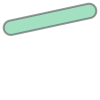

In [10]:
# orig and dest points to wgs
orig_point_wgs = orig_point.to_crs(epsg=4326)
dest_point_wgs = dest_point.to_crs(epsg=4326)

# Combine the dest and orig points
extent_points = orig_point_wgs.append(dest_point_wgs)

# Create a convex hull
graph_extent = extent_points.unary_union.convex_hull

# Conditional buffer to limit network size for walking
if travel_mode == 'walk' or 'bike':
    buffer = 0.025
else:
    buffer = 0.05

# Buffer
graph_extent = graph_extent.buffer(buffer)

# Check results
graph_extent

With the `graph_extent` polygon and the travel mode inforamtion I can now fetch the correctly sized street network from the correct location and of the correct type.

In [11]:
# Select OSM network type conditionally
if travel_mode == 'walk':
    network = 'walk'
if travel_mode == 'bike':
    network = 'bike'
if travel_mode == 'public':
    network = 'drive'
if travel_mode == 'car':
    network = 'drive'

# Get graph
graph = ox.graph_from_polygon(graph_extent, network_type=network)

Now I project the street network (`graph`) and the origin and destination points to the appropriate UTM zone.

In [12]:
# Project graph to UTM zone 35
graph_utm = ox.project_graph(graph)
nodes_utm, edges_utm = ox.graph_to_gdfs(graph_utm, nodes=True, edges=True)

# Project points to UTM zone 35
orig_point_utm = orig_point.to_crs(edges_utm.crs)
dest_point_utm = dest_point.to_crs(edges_utm.crs)

**3.2. Shortest path calculation**

With the street network and origin and destination points I calculate the shortest path and define its projection.

In [13]:
# Create GDF with a geometry column for the route
routes = gpd.GeoDataFrame()
routes['geometry'] = None

# Select origin location's y and x information
orig_yx = (orig_point_utm['geometry'].iloc[0].y, orig_point_utm['geometry'].iloc[0].x)
# Get node id (the id of the graph's nearest node to origin point)
orig_node_id = ox.get_nearest_node(graph_utm, orig_yx, method='euclidean')
# Get node
orig_node = nodes_utm.loc[orig_node_id]

# Select destination y and x
dest_yx = (dest_point_utm['geometry'].iloc[0].y, dest_point_utm['geometry'].iloc[0].x)
# Get node id
dest_node_id = ox.get_nearest_node(graph_utm, dest_yx, method='euclidean')
# Get node
dest_node = nodes_utm.loc[dest_node_id]

# Only calculate route when the start and destination node IDs are different
if dest_node_id != orig_node_id:
    # Get shortest path
    route = nx.shortest_path(graph_utm, source=orig_node_id, target=dest_node_id, weight='length')
    # Get route nodes
    route_nodes = nodes_utm.loc[route]
    # Construct route line
    route_line = LineString(list(route_nodes.geometry.values))
    # Add line to lines column
    routes.at[0, 'geometry'] = route_line
    
# Define routes crs
routes.crs = edges_utm.crs
# Check crs results
routes.crs

<Projected CRS: +proj=utm +zone=35 +ellps=WGS84 +datum=WGS84 +unit ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 35N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

**3.3. Visual evaluation of solution so far** 

At this point I visually check if my solution makes sense. I do this by by plotting the origin and destination points, their nearest grid cells and the road graph as a simple map. This visual approach also helped me to understand how different buffer values affect the graph extent. 

I also noticed that the shape of the road network on the map below doesn't seem to match the shape of the polygon used to fetch it. This happens because the polygon-based graph selection happens in WGS while the map here is projected in UTM zone 35: the shapes actually do match while the projections do not.

In [14]:
# Select the cells to plot
orig_cell = tt_grid['geometry'].loc[tt_grid['YKR_ID'] == orig_YKR]
dest_cell = tt_grid['geometry'].loc[tt_grid['YKR_ID'] == dest_YKR]

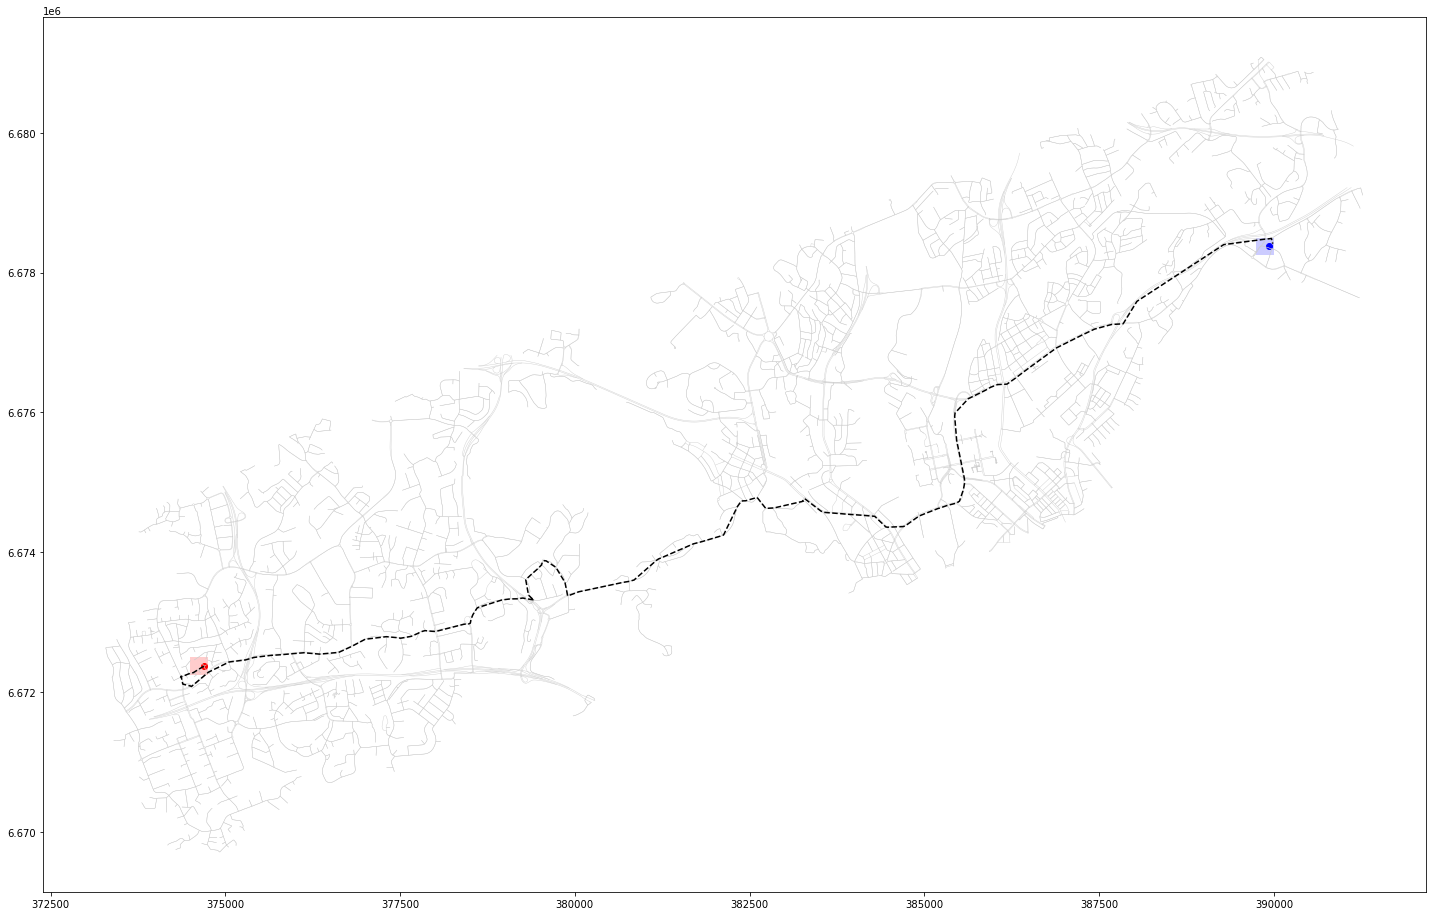

In [15]:
# Set up the plot
fig, ax = plt.subplots(figsize=(20,14))

# Plot graph edges
edges_utm.plot(ax=ax, color=[0.8,0.8,0.8], linewidth=0.4)

# Plot grid cells
orig_cell.plot(ax=ax, facecolor=[1,0.8,0.8])
dest_cell.plot(ax=ax, facecolor=[0.8,0.8,1])

# Plot route
routes.plot(ax=ax, color=[0,0,0], linestyle='--')

# Plot points
orig_point.plot(ax=ax, color=[1,0,0])
dest_point.plot(ax=ax, color=[0,0,1])

plt.tight_layout()

## 4. Visualization

**4.1. final preparations of the data:**

At this point I have all of the data that i need to plot an interactive map of the route and it's information. Some adjustments are still needed: 

First I set the route crs to Web Mercator for folium-plotting.

In [16]:
# Prepare data for the plotting of the interactive map
routes_wm = routes.to_crs(epsg=3857)

And then I do some string replacing as Folium doesn't seem to like scandic letters. Here I replace the scandics from the origin and destination addresses for cleaner output in the finished map.

In [17]:
# Create a list of tuples (scandic letters and their replacements)
scand_replacement = [('å', 'a'), ('ä', 'a'), ('ö', 'o'), ('Å', 'A'), ('Ä', 'A'), ('Ö', 'O')]

# New variables for formatted addresses
orig_address_formatted = orig_address
dest_address_formatted = dest_address

# Replace scandic letters using a for loop
for o, r in scand_replacement:
    orig_address_formatted = orig_address_formatted.replace(o, r)
    dest_address_formatted = dest_address_formatted.replace(o, r)

**4.2. Plotting the interactive map**

Here I plot the map using Folium.

In [18]:
# Create a map instance
m = folium.Map(
    # Use a neutral background map
    tiles='CartoDB positron',
    overlay=True,
    control_scale=True
)


# Add the route line to the map with quite counter-intuitive syntax
folium.Choropleth(
    routes_wm[routes_wm.geometry.length>0.001],
    line_weight=3,
    line_color='cadetblue'
).add_to(m)
 

# Define orig and dest point tooltips
orig_tooltip = (
    'Origin<br><br>Address: '+
    orig_address_formatted+
    '<br>Departure time: '+
    departure_time_formatted
)
dest_tooltip = (
    'Destination<br><br>Address: '+ 
    dest_address_formatted+
    '<br>Estimated arrival time: '+
    eta_formatted
)

# Define route length for route tooltip
route_length = int(routes['geometry'].iloc[0].length)

# Define route tooltip (add traffic forecast only if travel mode is affected by road traffic)
if travel_mode == 'public' or travel_mode == 'car':
    route_tooltip = (
        'Shortest route <br><br>Distance: '+
        str(route_length)+
        ' m<br>Travel time: '+
        travel_time_formatted+
        '<br>Travel mode: '+
        travel_mode+
        '<br>Estimated traffic: '+
        traffic_forecast
    )
else:
    route_tooltip = (
        'Shortest route <br><br>Distance: '+
        str(route_length)+
        ' m<br>Travel time: '+
        travel_time_formatted+
        '<br>Travel mode: '+
        travel_mode
    )


# Add markers

# Get the origin and destination points in yx format and in wgs 
orig_point_wgs_yx = [orig_point_wgs['geometry'].iloc[0].y, orig_point_wgs['geometry'].iloc[0].x]
dest_point_wgs_yx = [dest_point_wgs['geometry'].iloc[0].y, dest_point_wgs['geometry'].iloc[0].x]

# Origin
folium.Marker(
    orig_point_wgs_yx,
    tooltip=orig_tooltip,
    icon=folium.Icon(icon='arrow-up', color='red')
).add_to(m)

# Destination
folium.Marker(
    dest_point_wgs_yx,
    tooltip=dest_tooltip,
    icon=folium.Icon(icon='arrow-down', color='blue')
).add_to(m)

# Add a transparent version of the route line with higher weight parameter (this results in a bigger area to hover the route with the mouse when viewing the map) 
folium.features.GeoJson(
    routes_wm,
    style_function=lambda x: {'color':'transparent','fillColor':'transparent','weight':45},
    tooltip=route_tooltip,
).add_to(m)


# Automatically zoom and center the map based on the extent of the orig and dest points
m.fit_bounds([orig_point_wgs_yx, dest_point_wgs_yx]) 

# Display map
m

**4.3. Saving the map**

To avoid unclear filenames or character errors I format the filepath used to save the map. I also add the origin and destination information to the filename. 

The desired filepath format is: `map/route_from_*origin*_to_*destination*.html`

In [19]:
# Create a list of tuples (characters and their replacments for the filename)
filename_format = [(' ', '_'), (',', '_'), ('.', '_')]

# Everything to lowercase (I use the already non-scandic versions of the addresses)
orig_filename = orig_address_formatted.lower()
dest_filename = dest_address_formatted.lower()

# Format with a loop
for o, r in filename_format:
    orig_filename = orig_filename.replace(o, r)
    dest_filename = dest_filename.replace(o, r)

# Use only the first word of address to avoid too lomg filenames
orig_filename = orig_filename.split('_', 1)[0]
dest_filename = dest_filename.split('_', 1)[0]

# Finished filepath
outfp = 'map/route_from_'+orig_filename+'_to_'+dest_filename+'.html'
print(outfp)

map/route_from_aamupaivankuja_to_viikinkaari.html


To avoid accumulating too many map files in the map folder I automatically delete the previous map when saving the current one.

In [20]:
# Deleting the previous map
folder = glob.glob('map/*')
for f in folder:
    os.remove(f)
    
# Saving the current map
m.save(outfp)

Done!

## Brief critical reflections on the tool

Overall I think the tool does its job fine. However, there are many areas of improvement, mostly when  it comes calculating the path that is shown on the final map. The most obvious aspect is the downloading of the street network based on convex hull, which is why some routes are impossible to route. It should also be noted that the fastest route and the shortest route are not always the same. This is especially obvious when the routing tool selects small roads with tons of intersections while using a nearby major road might increase the distance just a bit. Also, there is no public transportation graph available, so routes that could utilize the train network, for example, cannot be drawn.